In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, RMSprop, Adam, Adagrad
from keras.backend import learning_phase, function
import tensorflow as tf
import config
import utils
from model import custom_inceptionResnetV2_conv_global, custom_inceptionResnetV3_conv_global, custom_inceptionV3_attention, custom_inceptionV2_attention, model_segmentation
import cv2
from keras.callbacks import ModelCheckpoint
import json
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda, Reshape, Add, Resizing
from keras.models import Model
from keras.layers import Concatenate
from tensorflow.keras.utils import plot_model
from keras.layers import MaxPooling2D

In [2]:
total_train_images = utils.total_count_files(config.TRAIN_DIR)
print(total_train_images)

total_val_images = utils.total_count_files(config.TESTE_DIR)
print(total_val_images)

1082
471


In [3]:
def gaussian_filter(image):
    sigmaX = 10
    return cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), sigmaX), -4, 128)

In [4]:
dataset_train = ImageDataGenerator(
                                rescale=1/255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                preprocessing_function=gaussian_filter
                                )

train_generator = dataset_train.flow_from_directory(config.TRAIN_DIR,
                                                    classes = ["0", "1"],
                                                    target_size=config.image_size_gen,
                                                    batch_size=config.batch,
                                                    class_mode='categorical')

valida_generator = dataset_train.flow_from_directory(config.TESTE_DIR,
                                                    classes = ["0", "1"],
                                                    target_size=config.image_size_gen,
                                                    batch_size=config.batch,
                                                    class_mode='categorical')

Found 1082 images belonging to 2 classes.
Found 471 images belonging to 2 classes.


In [5]:
input_shape = (config.image_size)
input_tensor = Input(input_shape)

In [7]:
# get segmentation and inception model
model_seg = model_segmentation(input_tensor=input_tensor)
model_seg.load_weights('model_for_seg_best.h5')

model_inception = custom_inceptionV2_attention(input_tensor=input_tensor)
model_inception.load_weights('output/inceptionv2/attention/pesos_inception_best.h5')

base_model loaded


In [8]:
# Removendo a parte de decoficação da rede
#layer_feature_seg = model_seg.get_layer('output_feature')
layer_feature_seg = model_seg.output

# Removendo a parte de atenção da rede
#layer_feature_inception = model_inception.get_layer('global_average_pooling2d_3') 
layer_feature_inception = model_inception.get_layer('batch_normalization_407') 
#layer_feature_inception = model_inception.get_layer('conv2d_475')

In [9]:
feature_seg_output = layer_feature_seg
feature_inception_output = layer_feature_inception.output

In [1]:
model_seg_teste = Model(inputs=input_tensor, outputs=feature_seg_output)
model_seg_teste.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                            metrics = ['categorical_accuracy', 'accuracy' ])

model_incp_teste = Model(inputs=input_tensor, outputs=feature_inception_output)
model_incp_teste.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                            metrics = ['categorical_accuracy', 'accuracy' ])

predict = model_incp_teste.predict(make_seg_input())

NameError: name 'Model' is not defined

In [12]:
feature_seg_output

<KerasTensor: shape=(None, 256, 256, 1) dtype=float32 (created by layer 'seg_final_out')>

In [16]:
seg_feature = MaxPooling2D()(feature_seg_output)

c1 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(seg_feature)
c1 = tf.keras.layers.Dropout(0.2)(c1)
c1 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(seg_feature)

p2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(p1)
c2 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c2 = tf.keras.layers.Dropout(0.2)(c2)
c2 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)

c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c3)

c4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

In [18]:
inception_resize = Resizing(8, 8)(feature_inception_output)

In [20]:
i1 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inception_resize)
i1 = tf.keras.layers.Dropout(0.2)(i1)
i1 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(i1)

In [31]:
combined_features = tf.keras.layers.concatenate([p4, i1], axis=-1)

p5 = tf.keras.layers.MaxPooling2D(pool_size=(1, 1))(combined_features)
c5 = tf.keras.layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
c5 = tf.keras.layers.Dropout(0.2)(c5)
c5 = tf.keras.layers.Conv2D(256, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(c5)


In [23]:
c5

<KerasTensor: shape=(None, 8, 8, 256) dtype=float32 (created by layer 'conv2d_485')>

In [89]:
combined_features

<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'concatenate_31')>

In [32]:
x = GlobalAveragePooling2D()(c5)

In [33]:
x

<KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'global_average_pooling2d_4')>

In [34]:
x = Dense(units=256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = Dense(units=128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = Dense(units=64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = Dense(units=32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
classifier_output = Dense(1, activation='sigmoid', name='fc1_3')(x)

In [35]:
classifier_model = Model(inputs=input_tensor, outputs=classifier_output)

In [36]:
for layer in model_seg.layers:
    layer.trainable=False
    
for layer in model_inception.layers:
    layer.trainable=False

In [37]:
classifier_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                            metrics = ['categorical_accuracy', 'accuracy' ])

In [ ]:
plot_model(classifier_model, "output/merged_model_v4.png", show_shapes=True)

In [39]:
classifier_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d_238 (Conv2D)            (None, 256, 256, 32  896         ['lambda_1[0][0]']               
                                )                                                                 
                                                                                            

In [40]:

steps_train = int(total_train_images // config.batch)
steps_val = int(total_val_images // config.batch)

history = utils.LossHistory()
early_stopping = utils.set_early_stopping()
reduce_lr = utils.set_reduce_lr()

checkpoint_path = 'output/inceptionv2/normal/teste_full.h5'

checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='categorical_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')


hist = classifier_model.fit(train_generator,
                            steps_per_epoch = steps_train,
                            epochs = 5, #config.epochs,
                            callbacks=[history, early_stopping, reduce_lr, checkpoint],
                            validation_data = valida_generator,
                            validation_steps = steps_val)

Epoch 1/5
67/67 [==============================] - ETA: 0s - loss: 0.7336 - categorical_accuracy: 0.5047 - accuracy: 0.5000 
Epoch 1: categorical_accuracy improved from -inf to 0.50469, saving model to output/inceptionv2/normal\teste_full.h5
67/67 [==============================] - 2554s 38s/step - loss: 0.7336 - categorical_accuracy: 0.5047 - accuracy: 0.5000 - val_loss: 0.6932 - val_categorical_accuracy: 0.4806 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/5
 3/67 [>.............................] - ETA: 16:46 - loss: 0.6932 - categorical_accuracy: 0.5417 - accuracy: 0.5000

KeyboardInterrupt: 

In [16]:
def make_seg_input():
    image = cv2.imread('./datasets/PROCESSED/TESTE/1/parte_3_1493.png')
    image = gaussian_filter(image)
    image = cv2.resize(image, (256,256))
    img_tensor = np.expand_dims(image, axis=0)
    return img_tensor

In [132]:


#predict = model_seg_teste.predict(make_seg_input)

output_2d = predict.squeeze()


In [133]:
output_2d.shape

(6, 6, 1536)

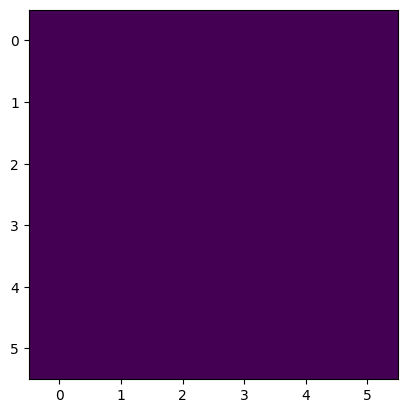

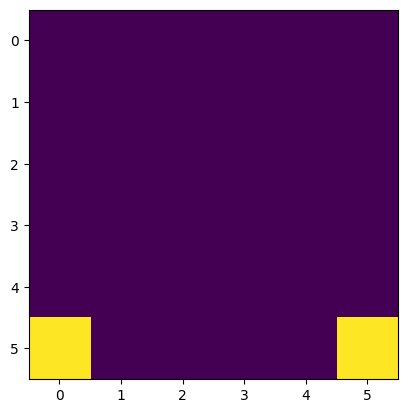

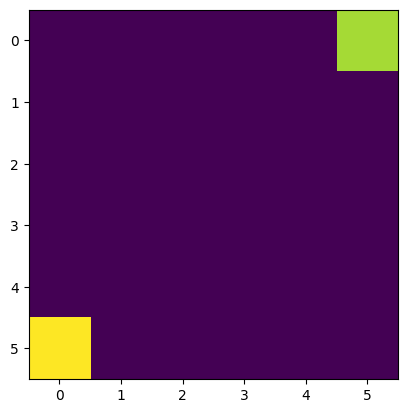

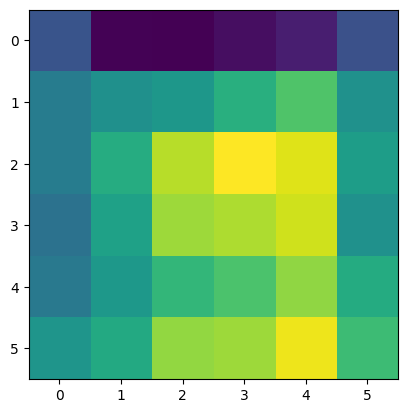

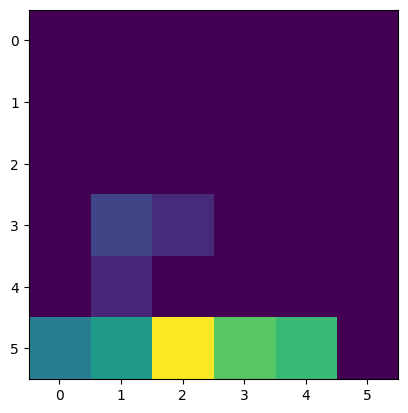

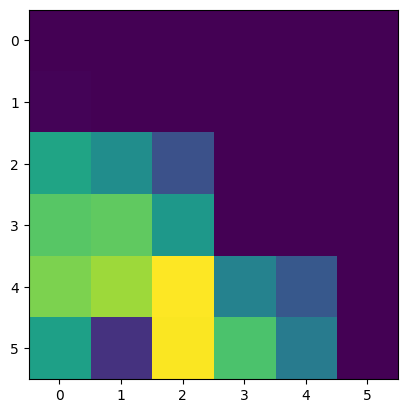

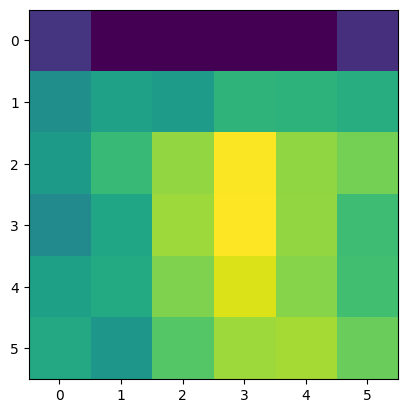

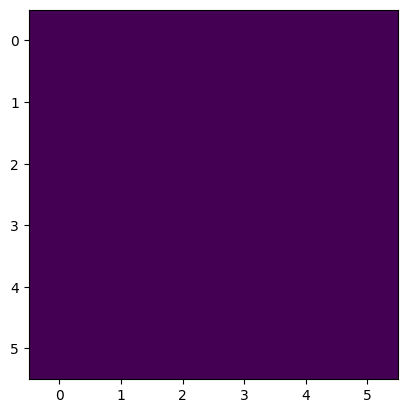

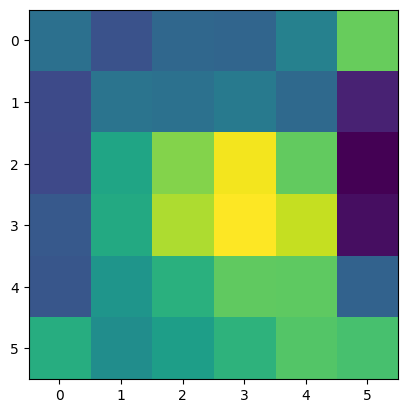

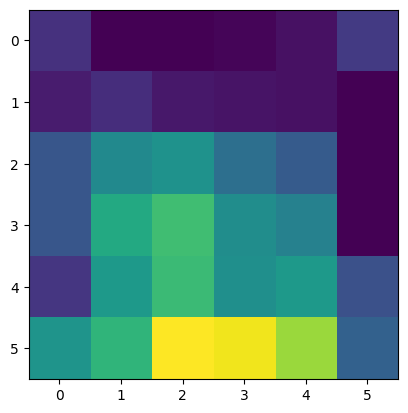

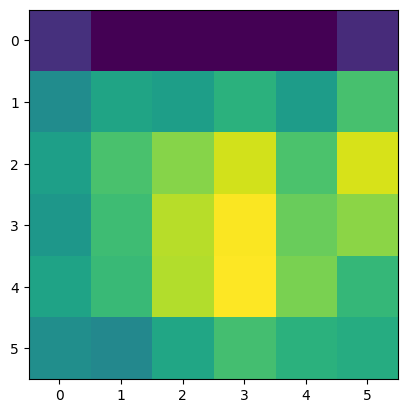

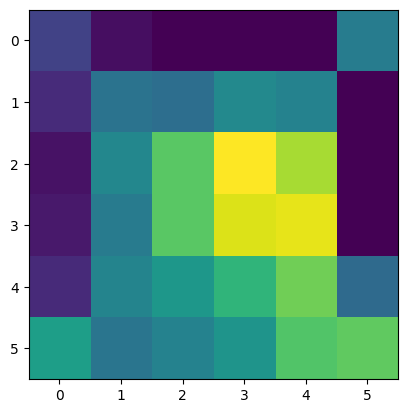

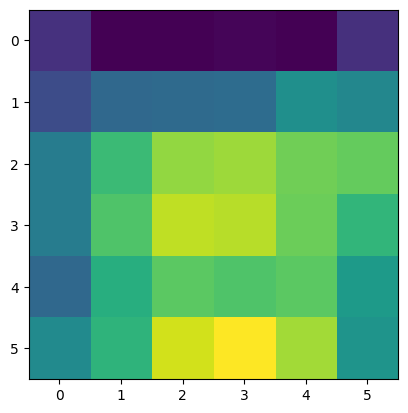

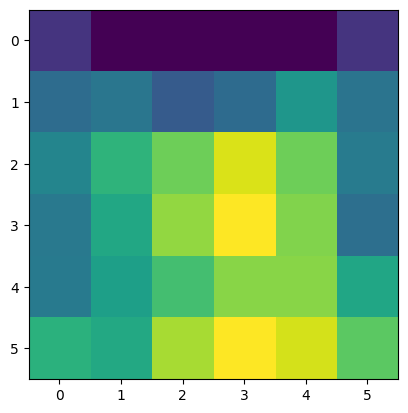

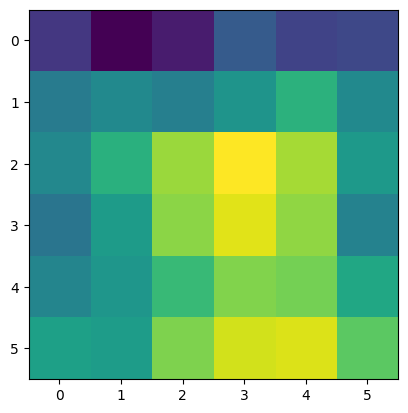

In [135]:
predict.shape
for i in range(15):
    plt.imshow(output_2d[:, :,i])
    plt.show()

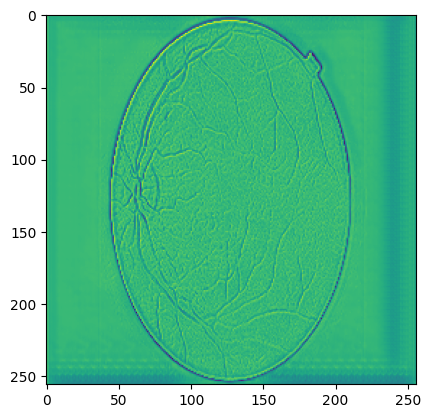

In [108]:
plt.imshow(output_2d[:, :, 7])

In [35]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [36]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(combined_features)

# Visualize the principal components
plt.scatter(principal_components[:,0], principal_components[:,1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(None, 1664), dtype=tf.float32, name=None), name='concatenate_20/concat:0', description="created by layer 'concatenate_20'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.

In [8]:
model_seg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
model_inception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

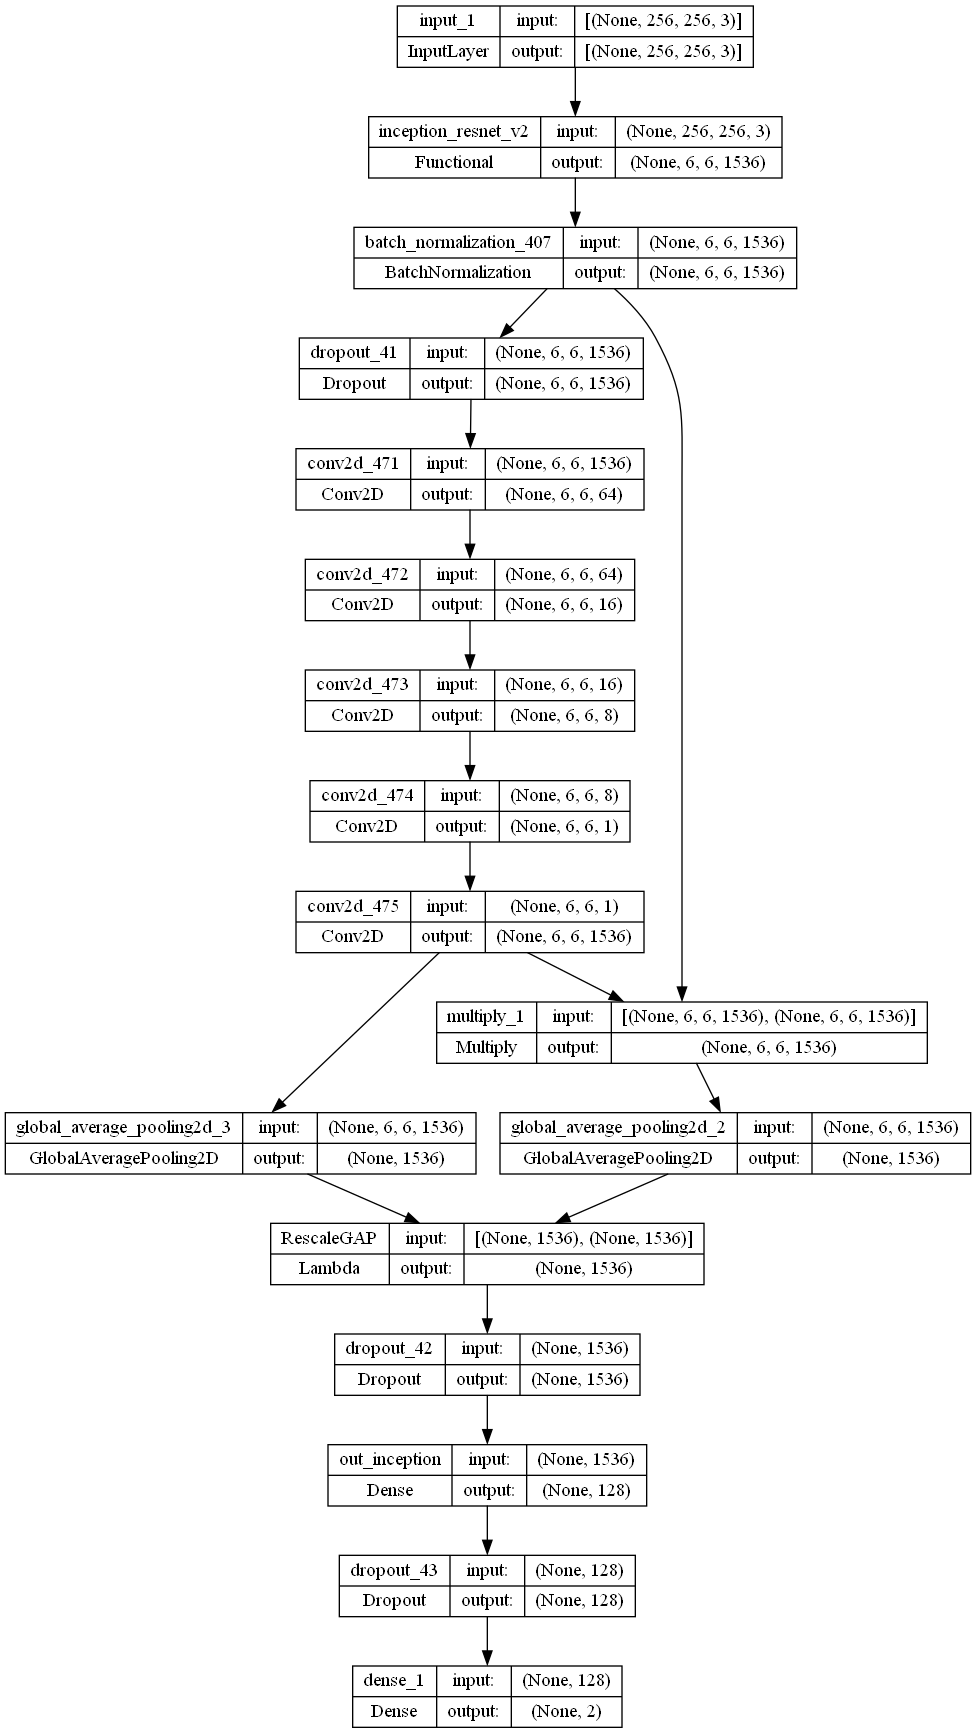

In [111]:
# plot_model(model_seg, "output/model_seg.png", show_shapes=True)
plot_model(model_inception, "output/model_inception_v2.png", show_shapes=True)

In [10]:
seg_output = model_seg.output

In [ ]:
# model_inception_output = model_inception(input_tensor)

In [15]:
for attn_layer in model_inception.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    layer_attn = attn_layer
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

In [17]:
model_inception.layers

In [13]:
attn_layer = Resizing(256, 256)(layer_attn.output)

In [23]:
connection = multiply([attn_layer, seg_output])

In [15]:
merged = Concatenate()([seg_output, attn_layer])

In [ ]:
# classifier_input = Input(shape=concatenated_output.shape[1:])

In [25]:
inputs = tf.keras.layers.Input(input_shape)

In [29]:
classifier_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d_239 (Conv2D)            (None, 256, 256, 32  896         ['lambda_1[0][0]']               
                                )                                                                 
                                                                                            

In [ ]:
merged_outputs = tf.keras.layers.concatenate([x, out_inception])

In [ ]:
seg_final = model_seg.get_layer('seg_final_out').output
x = GlobalAveragePooling2D(name='gl_avg_pool')(seg_final)

In [ ]:
x = Dense(units=128, activation='relu')(merged_outputs)
x = Dense(2, activation='softmax', name='fc1_3')(x)

In [ ]:
for layer in model_seg.layers:
    layer.trainable=False
    
for layer in model_class.layers:
    layer.trainable=False

In [ ]:
final_model = Model(inputs=merged_outputs, outputs=x)

In [ ]:
final_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                            metrics = ['categorical_accuracy'])

In [ ]:
steps_train = int(total_train_images // config.batch)
steps_val = int(total_val_images // config.batch)

history = utils.LossHistory()
early_stopping = utils.set_early_stopping()
reduce_lr = utils.set_reduce_lr()

checkpoint_path = 'output/inceptionv2/normal/teste_full.h5'

checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='categorical_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')


hist = final_model.fit(train_generator,
                            steps_per_epoch = steps_train,
                            epochs = config.epochs,
                            callbacks=[history, early_stopping, reduce_lr, checkpoint],
                            validation_data = valida_generator,
                            validation_steps = steps_val,
                            verbose = 2)



In [ ]:
checkpoint_path = 'output/inceptionv2/normal/teste_full.h5'

checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='categorical_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')


hist = final_model.fit(train_generator,
                            steps_per_epoch = steps_train,
                            epochs = config.epochs,
                            callbacks=[history, early_stopping, reduce_lr, checkpoint],
                            validation_data = valida_generator,
                            validation_steps = steps_val,
                            verbose = 2)


In [ ]:
img = tf.keras.preprocessing.image.load_img('./datasets/PROCESSED/TESTE/1/parte_3_1493.png', target_size=(256,256))
img_tensor = tf.keras.preprocessing.image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

In [ ]:
predict = model_seg.predict(img_tensor)

In [ ]:
output_2d = predict.squeeze()

In [ ]:
plt.imshow(output_2d, cmap='gray')
plt.show()